# 1.Import Library & DataSet

In [40]:
# Import Tensorflow & Keras
from tensorflow import keras
from keras.models import Model
from keras.layers import *
from keras.regularizers import l2
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import tensorflow as tf

# Helper libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import skimage
from skimage.transform import resize
import pandas as pd
import os

## 1.1 Load Label

In [99]:
l=0
for i in os.listdir('./data'):
    print(i,l)
    l+=1

bench 0
chair 1
office_chair 2
sofa 3


In [116]:
y=[];l=0
for i in os.listdir('./data'):
    for j in os.listdir('./data/'+i):
        y.append(l)
        #print(i,l)
    l+=1

In [117]:
y=np.array(y)
y=y.reshape(y.shape[0],1)

## 1.2 Load Image

In [102]:
#check max and min of Length, max and min of width
l_max=0;w_max=0;l_min=0;w_min=0
for i in os.listdir('./data'):
    for j in os.listdir('./data/'+i):
        path='./data/'+i+'/'+j
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        l_min=img.shape[0];w_min=img.shape[0]
        if(img.shape[0]>l_max):
            l_max=img.shape[0]
        if(img.shape[0]<l_min):
            l_min=img.shape[0]
        if(img.shape[1]>w_max):
            w_max=img.shape[1]
        if(img.shape[1]<w_min):
            w_min=img.shape[1]
print(l_max,l_min,w_max,w_min)

4167 473 4167 473


In [103]:
X=[]
for i in os.listdir('./data'):
    for j in os.listdir('./data/'+i):
        path='./data/'+i+'/'+j
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        #print(img.shape)
        img = skimage.transform.resize(img, (l_min, w_min))
        img = np.asarray(img)
        X.append(img)

C:\Users\user\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [104]:
X = np.asarray(X)
X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)

In [105]:
X.shape

(1158, 473, 473, 1)

In [229]:
test_labels[0]

array([3])

In [230]:
test_labels = to_categorical(np.array(test_labels[:, 0]))
test_labels[0]

array([0., 0., 0., 1.], dtype=float32)

## 1.3 Split data to train and test

In [228]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(926, 473, 473, 1) (926, 1) (232, 473, 473, 1) (232, 1)


In [ ]:
# bench 0, chair 1, office_chair 2, sofa 3

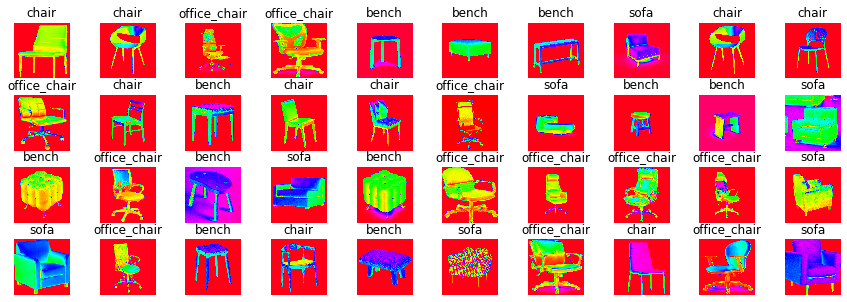

In [120]:
# dict
dictionary={0:"bench",1:"chair",2:"office_chair",3:"sofa"}
# visualizing training samples
plt.figure(figsize=(15,5))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(train_images[i].reshape(train_images.shape[1],train_images.shape[2]),cmap=plt.cm.hsv)
    #print(i)
    plt.title(dictionary[train_labels[i][0]])
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

# 2. Data Preprocess

In [137]:
# Normalize pixel values to be between 0 and 1
train_images.astype('float32');test_images.astype('float32')
train_images, test_images = train_images / 255.0, test_images / 255.0

In [138]:
# Encoding
train_labels = to_categorical(np.array(train_labels[:, 0]))
test_labels = to_categorical(np.array(test_labels[:, 0]))

# 3.Model Design
## 3.1 Squeeze and Excitation

In [124]:
def squeeze_excite_block(input, ratio=16):
    
    init = input
    filters = init._keras_shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)
    x = multiply([init, se])
    
    return x

## 3.2 ResNet

In [125]:
def resnet_block(input, filters, k=1, strides=(1, 1)):
    init = input
    channel_axis = -1 

    x = BatchNormalization(axis=channel_axis)(input)
    x = Activation('relu')(x)

    if strides != (1, 1) or init._keras_shape[channel_axis] != filters * k:
        init = Conv2D(filters * k, (1, 1), padding='same', kernel_initializer='he_normal',
                      use_bias=False, strides=strides)(x)

    x = Conv2D(filters * k, (3, 3), padding='same', kernel_initializer='he_normal',
               use_bias=False, strides=strides)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters * k, (3, 3), padding='same', kernel_initializer='he_normal',
               use_bias=False)(x)

    # squeeze and excite block
    x = squeeze_excite_block(x)

    m = add([x, init])
    return m

## 3.3 SE_ResNet

In [126]:
def create_se_resnet(classes, img_input, include_top, initial_conv_filters, filters,
                      depth, width, weight_decay, pooling):

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    N = list(depth)

    x = Conv2D(initial_conv_filters, (7, 7), padding='same', use_bias=False, strides=(2, 2),
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(img_input)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    for i in range(N[0]):
            x = resnet_block(x, filters[0], width)

    for k in range(1, len(N)):
            x = resnet_block(x, filters[k], width, strides=(2, 2))

    for i in range(N[k] - 1):
            x = resnet_block(x, filters[k], width)

    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)


    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  activation='softmax')(x)
    
    return x

# 4.Model Training

In [127]:
img_rows, img_cols = l_min, w_min
input_shape = (img_rows, img_cols, 1)
initial_conv_filters=64
depth=[2, 2, 2, 2]
filters=[64, 128, 256, 512]
width=1
weight_decay=1e-4
include_top=True
weights=None
input_tensor=None
pooling=None
classes=4

img_input = Input(shape=input_shape)
   
x = create_se_resnet(classes, img_input, include_top, initial_conv_filters,
                          filters, depth, width, weight_decay, pooling)

model = Model(img_input, x, name='resnext')
print('model created')
    
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

model created
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 473, 473, 1)  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 237, 237, 64) 3136        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 119, 119, 64) 0           conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 119, 119, 64) 256         max_pooling2d_4[0][0]            
_______________________________________________________________________________________________

In [129]:
history = model.fit(train_images, train_labels, epochs=20, validation_split=0.25)

Train on 694 samples, validate on 232 samples
Epoch 1/20
694/694 [==============================] - 1118s 2s/step - loss: 0.9938 - acc: 0.6110 - val_loss: 2.0223 - val_acc: 0.5043
Epoch 2/20
694/694 [==============================] - 1095s 2s/step - loss: 0.6113 - acc: 0.7622 - val_loss: 2.4759 - val_acc: 0.5733
Epoch 3/20
694/694 [==============================] - 1070s 2s/step - loss: 0.4626 - acc: 0.8271 - val_loss: 1.9876 - val_acc: 0.5733
Epoch 4/20
694/694 [==============================] - 1067s 2s/step - loss: 0.3650 - acc: 0.8573 - val_loss: 1.5996 - val_acc: 0.6336
Epoch 5/20
694/694 [==============================] - 1073s 2s/step - loss: 0.3048 - acc: 0.8919 - val_loss: 9.0828 - val_acc: 0.2931
Epoch 6/20
694/694 [==============================] - 1048s 2s/step - loss: 0.2109 - acc: 0.9251 - val_loss: 1.9470 - val_acc: 0.6379
Epoch 7/20
694/694 [==============================] - 1024s 1s/step - loss: 0.2193 - acc: 0.9265 - val_loss: 6.7150 - val_acc: 0.3491
Epoch 8/20
694/6

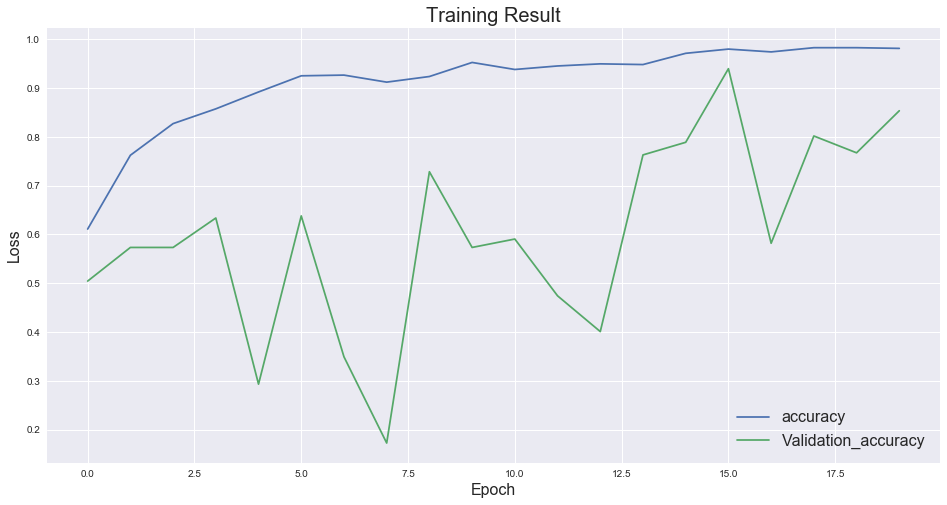

In [133]:
plt.style.use('seaborn')
plt.figure(figsize = (16,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training Result',fontsize=20)
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['accuracy','Validation_accuracy'], loc='lower right',fontsize=16)
plt.show()

In [131]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('accuracy: ',score[1])
print('loss: ',score[0])

accuracy:  0.853448275862069
loss:  0.46818723144202395


In [132]:
from keras.models import load_model
model.save('model.h5')  # creates a HDF5 file 'model.h5'

# 6.Predict Result Review

In [157]:
# bench 0, chair 1, office_chair 2, sofa 3
import matplotlib.pyplot as plot
import math
label_desc = [ 'bench', 'chair', 'office_chair', 'sofa' ]
def show_feature_label_prediction( features
                                 , labels
                                 , predictions
                                 , indexList
                                 ) :
    num = len(indexList)
    plot.gcf().set_size_inches( 2*5, (2+0.4)*math.ceil(num/5) )
    loc = 0
    for i in indexList :
        loc += 1
        subp = plot.subplot( math.ceil(num/5), 5, loc )
        img=features[i].reshape(features[i].shape[0],features[i].shape[1])
        subp.imshow(img, cmap='binary' )
        if( len(predictions) > 0 ) :
            title = 'ai = ' + label_desc[ predictions[i] ]
            title += (' (o)' if predictions[i]==labels[i] else ' (x)')
            title += '\nlabel = ' + label_desc[ labels[i] ]
        else :
            title = 'label = ' + label_desc[ labels[i] ]
        subp.set_title( title, fontsize=12 )
        subp.set_xticks( [] )
        subp.set_yticks( [] )
    plot.show()

In [195]:
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)
# Normalize pixel values to be between 0 and 1
train_images.astype('float32');test_images.astype('float32')
train_images, test_images = train_images / 255.0, test_images / 255.0

(926, 473, 473, 1) (926, 1) (232, 473, 473, 1) (232, 1)


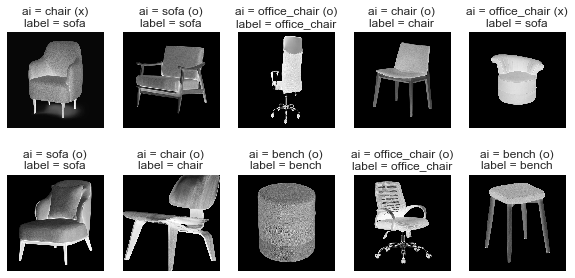

In [196]:
predict = model.predict(test_images)
predict=np.argmax(predict,axis=1)
test_label_onearr = test_labels.reshape(len(test_labels))
show_feature_label_prediction(test_images, test_label_onearr, predict, range(0, 10) )

## Confusion Matrix

In [223]:
class_names=['bench', 'chair', 'office_chair', 'sofa']

In [210]:
cm = confusion_matrix(y_true, predict)
cm

array([[34,  7,  4,  2],
       [ 0, 74,  6,  0],
       [ 0,  0, 69,  0],
       [ 3,  4,  8, 21]], dtype=int64)

In [212]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm

array([[0.72, 0.15, 0.09, 0.04],
       [0.  , 0.93, 0.07, 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.08, 0.11, 0.22, 0.58]])

In [220]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [217]:
y_true = test_labels.reshape(test_labels.shape[0])

In [218]:
class_names=['bench', 'chair', 'office_chair', 'sofa']

Confusion matrix, without normalization


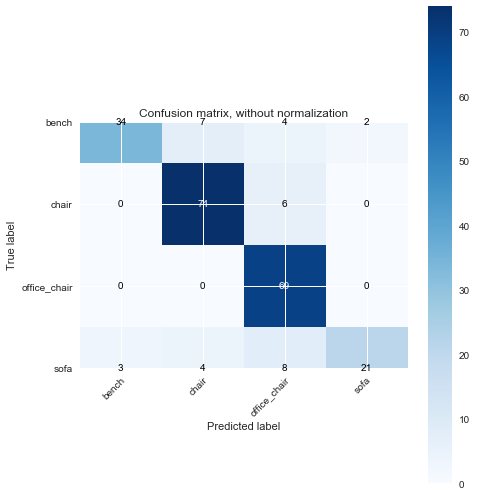

In [221]:
# Plotting non-normalized confusion matrix
class_names=['bench', 'chair', 'office_chair', 'sofa']
plot_confusion_matrix(y_true, predict, classes = class_names, title='Confusion matrix, without normalization')

Normalized confusion matrix


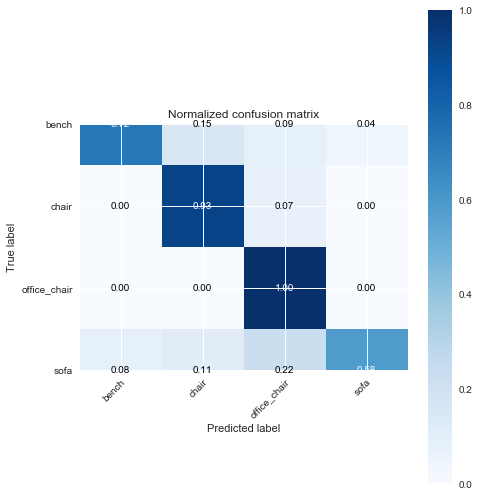

In [222]:
plot_confusion_matrix(y_true, predict, classes = class_names, normalize = True, title = 'Normalized confusion matrix')

## Top-20 predict error list

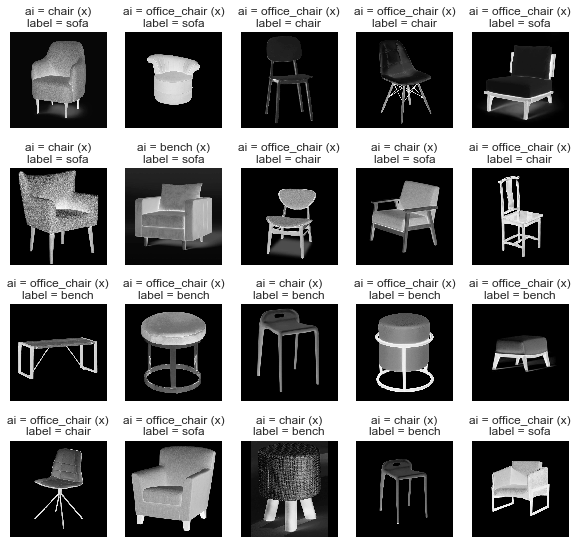

In [202]:
checkList = pd.DataFrame( {'label':test_label_onearr,'prediction':predict})
show_feature_label_prediction(test_images, test_label_onearr, predict, checkList.index[checkList.prediction != checkList.label][0:20])